<a href="https://colab.research.google.com/github/emmaebrl/LASCAR/blob/main/EDA_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio joblib

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.plot import show
from glob import glob

from joblib import Parallel, delayed
from tqdm import tqdm

In [3]:
train_images_dir = '/content/drive/MyDrive/LASCAR/data/train/images'
train_masks_dir = '/content/drive/MyDrive/LASCAR/data/train/masks'
test_images_dir = '/content/drive/MyDrive/LASCAR/data/test'

csv_path = '/content/drive/MyDrive/LASCAR/data/train_labels_GY1QjFw.csv'
df_labels = pd.read_csv(csv_path)

print("CSV:")
print(df_labels.shape)
df_labels.head()

CSV:
(18491, 11)


,sample_id,no_data,clouds,artificial,cultivated,broadleaf,coniferous,herbaceous,natural,snow,water
0,1,0.0,0.0,0.032867,0.743835,0.054214,0.000565,0.168518,0.0,0.0,0.000000
1,2,0.0,0.0,0.094040,0.759445,0.025238,0.000320,0.120544,0.0,0.0,0.000412
2,3,0.0,0.0,0.043762,0.575974,0.061676,0.001053,0.317535,0.0,0.0,0.000000
3,4,0.0,0.0,0.007538,0.116974,0.448486,0.042938,0.382553,0.0,0.0,0.001511
4,5,0.0,0.0,0.022217,0.279907,0.414169,0.013840,0.268982,0.0,0.0,0.000885


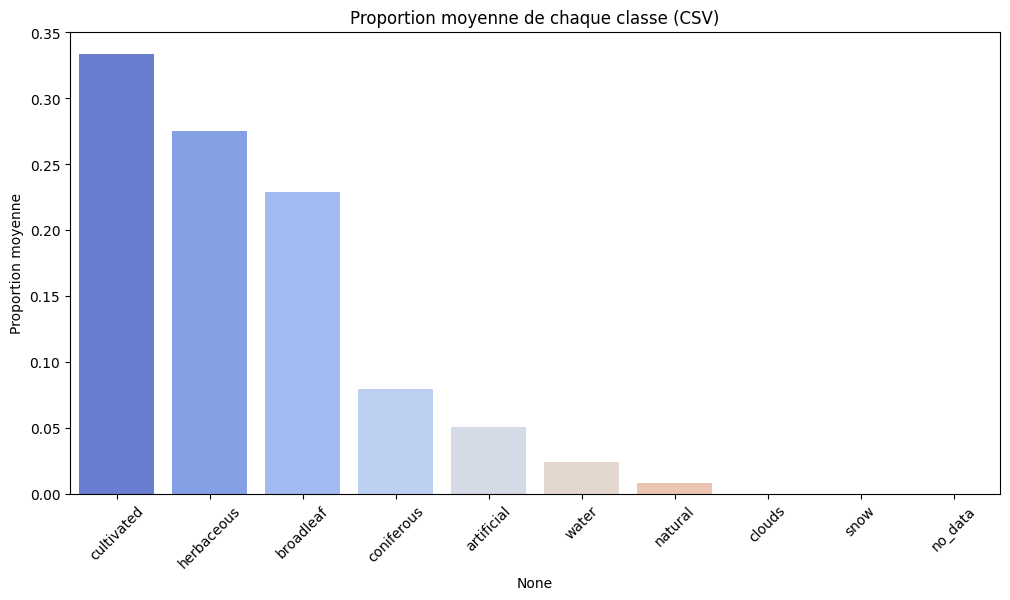

In [4]:
# Supposons que les colonnes du CSV soient comme : ['image_name', 'class_0', 'class_1', ..., 'class_n']
df_labels.set_index('sample_id', inplace=True)

# Moyenne par classe
mean_per_class = df_labels.mean().sort_values(ascending=False)

# Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_per_class.index, y=mean_per_class.values, hue=mean_per_class.index, palette='coolwarm', legend=False)
plt.xticks(rotation=45)
plt.title("Proportion moyenne de chaque classe (CSV)")
plt.ylabel("Proportion moyenne")
plt.show()


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Image shape: (4, 256, 256)
Mask shape: (256, 256)


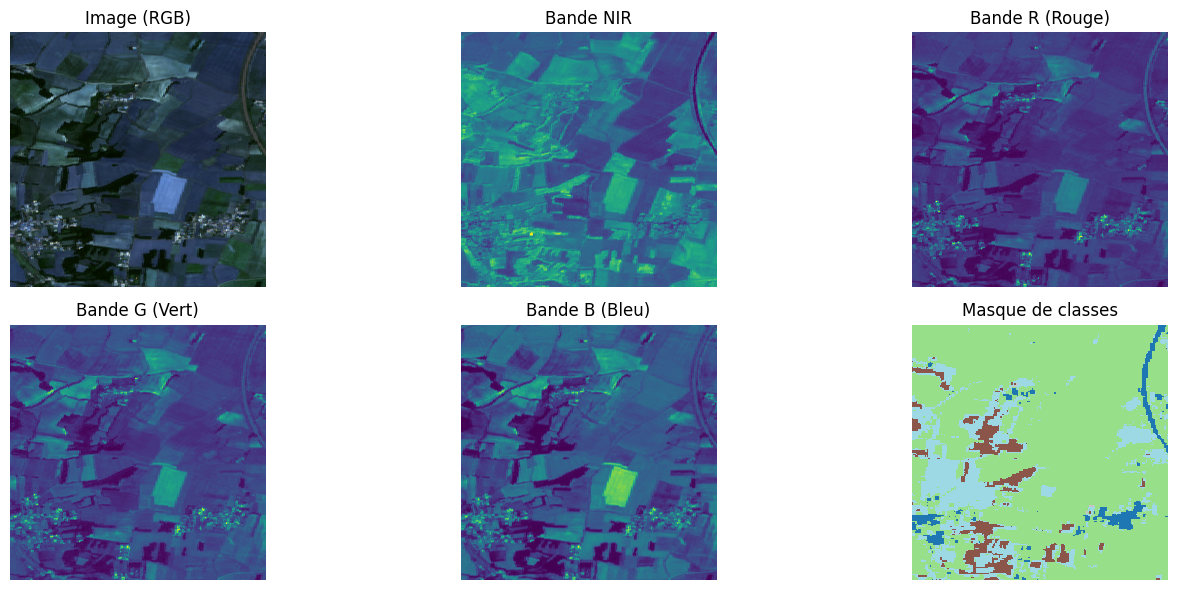

In [5]:
def show_image_and_mask(image_path, mask_path):
    with rasterio.open(image_path) as img_src:
        image = img_src.read()  # (4, H, W)
        print("Image shape:", image.shape)

    with rasterio.open(mask_path) as mask_src:
        mask = mask_src.read(1)
        print("Mask shape:", mask.shape)

    # Composite RGB
    rgb = np.stack([image[0], image[1], image[2]], axis=-1).astype(np.float32)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

    fig, axs = plt.subplots(2, 3, figsize=(15, 6))

    axs[0, 0].imshow(rgb)
    axs[0, 0].set_title("Image (RGB)")
    axs[0, 0].axis('off')

    axs[0, 1].imshow(image[3],cmap = "viridis")
    axs[0, 1].set_title("Bande NIR")
    axs[0, 1].axis('off')

    axs[0, 2].imshow(image[0],cmap = "viridis")
    axs[0, 2].set_title("Bande R (Rouge)")
    axs[0, 2].axis('off')

    axs[1, 0].imshow(image[1],cmap = "viridis")
    axs[1, 0].set_title("Bande G (Vert)")
    axs[1, 0].axis('off')

    axs[1, 1].imshow(image[2],cmap = "viridis")
    axs[1, 1].set_title("Bande B (Bleu)")
    axs[1, 1].axis('off')

    axs[1, 2].imshow(mask, cmap='tab20')
    axs[1, 2].set_title("Masque de classes")
    axs[1, 2].axis('off')

    plt.tight_layout()
    plt.show()


example_image = sorted(glob(os.path.join(train_images_dir, '*.tif')))[0]
example_mask = os.path.join(train_masks_dir, os.path.basename(example_image))
show_image_and_mask(example_image, example_mask)


## 🛰️ Pourquoi des images à 4 bandes (R-G-B-NIR) ?

Contrairement aux images classiques en 3 canaux (R-G-B), les images satellites fournissent une **bande supplémentaire : le NIR (Infrarouge Proche)**.

| Bande | Longueur d’onde | Ce qu’elle capte                 |
|-------|------------------|----------------------------------|
| R     | ~600–700 nm      | Sol, zones bâties, végétation sèche |
| G     | ~500–600 nm      | Végétation, eau                  |
| B     | ~400–500 nm      | Ombres, neige, eau              |
| NIR   | ~700–900 nm      | 🌿 **Végétation vivante**, santé des plantes |

🔎 **Pourquoi 4 bandes ?**  
- Chaque bande réagit différemment selon la nature du sol ou de la surface.
- En combinant les 4, on améliore la **capacité du modèle à distinguer les classes** similaires visuellement (ex : champ vs forêt).
- Le NIR est **invisible à l’œil humain**, mais essentiel pour détecter la végétation.

---

## 📈 Comment on les utilise dans la segmentation ?

### 🔹 En entrée du modèle :
- On donne les 4 bandes (R-G-B-NIR) comme **4 canaux** à un modèle (ex : U-Net)
- Cela permet au modèle d’apprendre des **signatures spectrales** spécifiques à chaque classe

### 🔹 Pour l'exploration des données :
- On visualise :
  - Les 3 bandes RGB ensemble (vue naturelle)
  - Le NIR seul (végétation)
  - Des fausses couleurs (NIR-R-G) pour mieux détecter la verdure

### 🔹 Pour l'analyse :
- On calcule l’**indice NDVI** à partir de NIR et Rouge
- On observe la **corrélation entre NDVI et les classes du masque**
  - Ex : forte corrélation NDVI ↔ forêt
  - Faible corrélation NDVI ↔ route, eau


In [6]:
# Récupération des noms sans extension
image_files = set(os.path.splitext(os.path.basename(p))[0] for p in glob(os.path.join(train_images_dir, '*.tif')))
mask_files = set(os.path.splitext(os.path.basename(p))[0] for p in glob(os.path.join(train_masks_dir, '*.tif')))
csv_files = set(df_labels.index)

# Comparaison
missing_masks = image_files - mask_files
missing_csv = image_files - csv_files

print(f"{len(missing_masks)} images sans masque")
print(f"{len(missing_csv)} images sans ligne CSV")

### Le code est faux ou alors y'a un problème d'id ??


17 images sans masque
18508 images sans ligne CSV


In [7]:
image_paths = sorted(glob(os.path.join(train_images_dir, '*.tif')))

def extract_band_means(image_path):
    try:
        with rasterio.open(image_path) as src:
            img = src.read().astype(np.float32)  # (4, H, W)
            means = np.mean(img, axis=(1, 2))    # Moyenne pour chaque bande
            del img  # 💥 Libère explicitement la mémoire de l’image
            gc.collect()
        return (os.path.splitext(os.path.basename(image_path))[0], means)
    except Exception as e:
        print(f"Erreur avec {image_path}: {e}")
        return None


results = Parallel(n_jobs=-1)(delayed(extract_band_means)(path) for path in tqdm(image_paths))
results = [r for r in results if r is not None]

 10%|▉         | 1788/18508 [1:50:23<35:07:34,  7.56s/it]

KeyboardInterrupt: 

In [ ]:
df_bands = pd.DataFrame({image_id: bands for image_id, bands in results}).T
df_bands.columns = ['mean_R', 'mean_G', 'mean_B', 'mean_NIR']
df_bands.index.name = 'image_name'

df_merged = df.join(df_bands)

correlation_matrix = df_merged.corr()

band_cols = ['mean_R', 'mean_G', 'mean_B', 'mean_NIR']
class_cols = [col for col in df.columns if col not in band_cols]

corr_bands_vs_classes = correlation_matrix.loc[band_cols, class_cols]

plt.figure(figsize=(12, 6))
sns.heatmap(corr_bands_vs_classes, annot=True, cmap='coolwarm', center=0)
plt.title("Corrélation entre les bandes spectrales et les proportions de classes")
plt.tight_layout()
plt.show()